Shape of predicted_labels: (1672,)
Shape of ground_truths: (1672,)
Model accuracy: 91.75%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


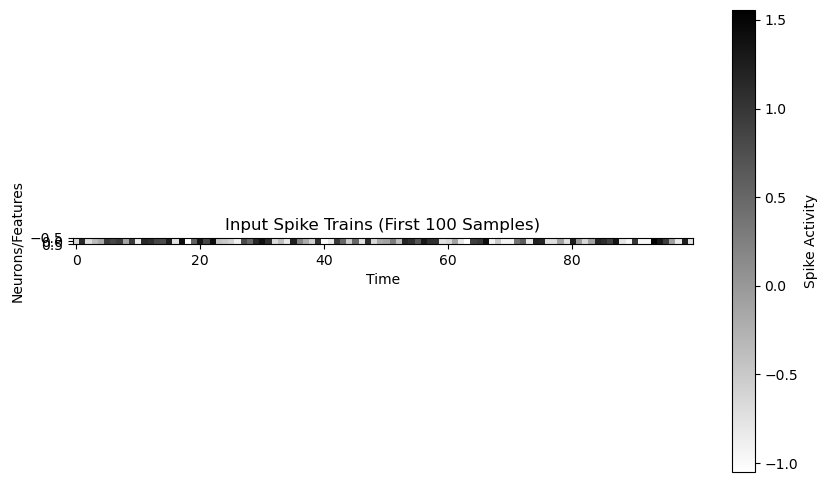

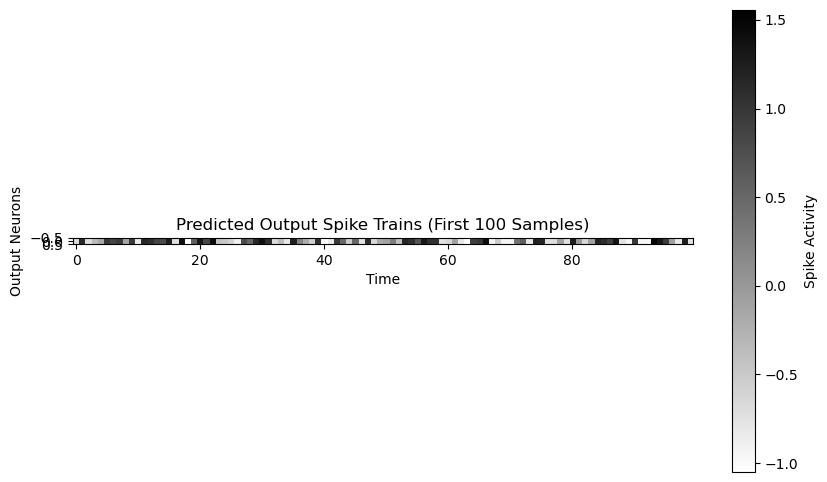

Final Accuracy: 0.89


In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load the model outputs from the .pkl file
with open('model2_vmem_4810.pkl', 'rb') as f:
    model2_outputs = pickle.load(f)

# Extract predictions and ground truths
predictions = model2_outputs['predictions']  # This should be spike outputs or activations
ground_truths = model2_outputs['ground_truths']  # Ground truth labels

# Convert the predictions to binary labels (1 for target class, 0 for non-target class)
threshold = 0  # Adjust the threshold for binary classification
predicted_labels = np.where(predictions > threshold, 1, 0)   
predicted_labels = predicted_labels.flatten()

# Flatten the ground truths array (from 2D to 1D)
ground_truths = np.array(ground_truths).flatten()

# Debugging outputs
print(f"Shape of predicted_labels: {predicted_labels.shape}")
print(f"Shape of ground_truths: {ground_truths.shape}")

# Accuracy Calculation
correct_predictions = (predicted_labels == ground_truths).sum()
total_predictions = ground_truths.shape[0]
accuracy = (correct_predictions / total_predictions) * 100
print(f"Model accuracy: {accuracy:.2f}%")

# ---- Precision, Recall, and F1 Score Calculation ----
def precision_recall_f1(predicted_labels, ground_truths):
    tp = np.sum((predicted_labels == 1) & (ground_truths == 1))
    fp = np.sum((predicted_labels == 1) & (ground_truths == 0))
    fn = np.sum((predicted_labels == 0) & (ground_truths == 1))

    precision = tp / (tp + fp + 1e-6)  # Small epsilon to prevent division by zero
    recall = tp / (tp + fn + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return precision, recall, f1_score

# Calculate precision, recall, and F1 score
precision, recall, f1_score = precision_recall_f1(predicted_labels, ground_truths)

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# ---- Visualization of Input and Output Spikes ----

# Visualize input spikes (replace 'spikes_tensor' with the actual input spike data)
plt.figure(figsize=(10, 6))
input_spikes = predictions[:100, :10]  # Visualizing the first 100 samples and 10 features
plt.imshow(input_spikes.T, cmap='binary', interpolation='nearest')
plt.colorbar(label='Spike Activity')
plt.title('Input Spike Trains (First 100 Samples)')
plt.xlabel('Time')
plt.ylabel('Neurons/Features')
plt.show()

# Visualize predicted output spikes
plt.figure(figsize=(10, 6))
predicted_spikes = predictions[:100]  # First 100 output spike trains
plt.imshow(predicted_spikes.T, cmap='binary', interpolation='nearest')
plt.colorbar(label='Spike Activity')
plt.title('Predicted Output Spike Trains (First 100 Samples)')
plt.xlabel('Time')
plt.ylabel('Output Neurons')
plt.show()

# ---- Overall Model Accuracy Measurement ----
threshold = 0.5  # Adjust as necessary
predicted_binary_labels = (predictions > threshold).astype(int).flatten()

# Count the number of correct predictions
correct = np.sum(predicted_binary_labels == ground_truths)
total = len(ground_truths)

# Calculate and print accuracy
accuracy = correct / total
print(f"Final Accuracy: {accuracy:.2f}")


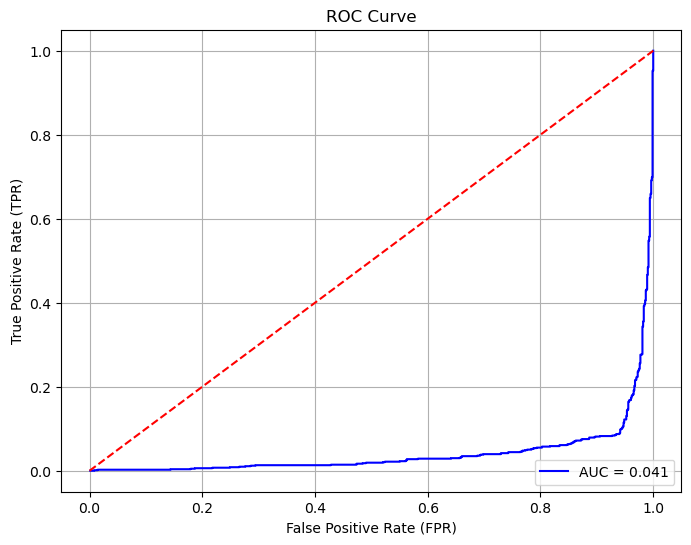

In [2]:
# Extract predictions and ground truths from the loaded dictionary
predictions1 = model2_outputs.get('predictions', None)
ground_truths1 = model2_outputs.get('ground_truths', None)

# Check if the data was loaded correctly
if predictions1 is None or ground_truths1 is None:
    raise ValueError("Predictions or ground_truths not found in the file.")

# Define the ROC AUC calculation function
def calculate_roc_auc(predictions, ground_truths):
    # Ensure predictions are 1D
    preds = predictions.flatten()
    
    # Sort predictions and corresponding ground truth
    sorted_indices = np.argsort(preds)
    sorted_preds = preds[sorted_indices]
    sorted_truths = ground_truths[sorted_indices]

    # Initialize true positive rate (TPR) and false positive rate (FPR)
    tprs = []
    fprs = []
    num_positives = np.sum(sorted_truths == 1)
    num_negatives = np.sum(sorted_truths == 0)
    
    # Initialize counts for TP and FP
    tp = 0
    fp = 0

    # Iterate over sorted predictions to compute TPR and FPR
    for i in range(len(sorted_preds)):
        if sorted_truths[i] == 1:
            tp += 1
        else:
            fp += 1

        # Calculate TPR and FPR
        tprs.append(tp / num_positives)
        fprs.append(fp / num_negatives)

    # Calculate AUC using the trapezoidal rule
    auc = np.trapz(tprs, fprs)

    return fprs, tprs, auc

# Calculate the ROC curve and AUC
fprs, tprs, auc = calculate_roc_auc(predictions1, ground_truths1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprs, tprs, label=f'AUC = {auc:.3f}', color='b')
plt.plot([0, 1], [0, 1], 'r--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

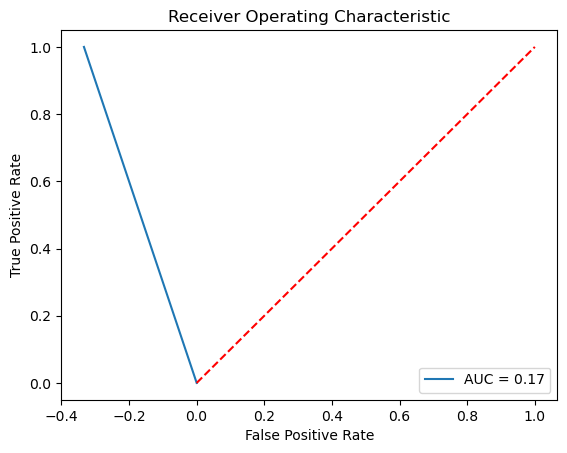

In [3]:
all_membrane_potentials = np.concatenate(model2_outputs['membrane_potentials'])

# Determine range for thresholds
min_potential = np.min(all_membrane_potentials)
max_potential = np.max(all_membrane_potentials)

# Create thresholds
thresholds = np.linspace(min_potential, max_potential, num=100)

outputs = np.concatenate(model2_outputs['predictions'])
ground_truths = np.array(model2_outputs['ground_truths'])

# Define ROC calculation function
def calculate_roc_curve(outputs, labels, thresholds):
    tprs = []
    fprs = []
    for threshold in thresholds:
        predicted_positives = outputs > threshold
        true_positives = np.sum(predicted_positives & labels)
        false_positives = np.sum(predicted_positives & ~labels)
        
        tpr = true_positives / np.sum(labels)  # TP / (TP + FN)
        fpr = false_positives / np.sum(~labels)  # FP / (TN + FP)
        
        tprs.append(tpr)
        fprs.append(fpr)
    
    return fprs, tprs

# Calculate TPRs and FPRs for the thresholds
fprs, tprs = calculate_roc_curve(outputs, ground_truths, thresholds)

# Calculate AUC using the trapezoidal rule
auc = np.trapz(tprs, fprs)

# Plotting ROC Curve
plt.figure()
plt.plot(fprs, tprs, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [5]:
print("Sample outputs:", outputs[:10])
print("Sample labels:", ground_truths[:10])

Sample outputs: [-0.68074274  1.1237557  -0.69996315 -0.35258368 -0.16817477  0.96331286
  0.83956146  0.9550959  -0.12528181  0.95359343]
Sample labels: [0 1 0 0 0 1 1 1 1 0]


In [6]:
# Manually verify a few thresholds
sample_threshold = np.median(outputs)
predicted_positives = outputs > sample_threshold
true_positives = np.sum(predicted_positives & ground_truths)
false_positives = np.sum(predicted_positives & ~ground_truths)

print("Threshold:", sample_threshold)
print("True Positives:", true_positives)
print("False Positives:", false_positives)

Threshold: 9.201775e-07
True Positives: 767
False Positives: 69
